# Experiments
Attention: The error bars are for the mean and not the samples itself.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.covariance import EmpiricalCovariance, LedoitWolf

import covariance_DRO

sns.set(rc={'figure.figsize':(5,3)})
sns.set_style("white")

import warnings
warnings.filterwarnings("ignore")

## Synthetic Data

In [2]:
def frob(X,Y):
    return np.linalg.norm(X-Y, ord='fro')

In [3]:
def LinearShrink(emp_cov, rho):
    mu = np.trace(emp_cov) / emp_cov.shape[0]
    cov = (1. - rho) * emp_cov
    cov.flat[::emp_cov.shape[0] + 1] += rho * mu
    return cov

In [4]:
def LinearShrinkDiag(emp_cov, rho):
    mu = np.diag(np.diag(emp_cov))
    cov = (1. - rho) * emp_cov + mu*rho
    return cov

In [5]:
def experiment(sigma, n_samples=[100, 200, 500], n_repetitions=100, epsilons=np.logspace(-5,1,50), rhos=np.logspace(-5,0,50), error_func=frob):
    baselines=[lambda X, rho: LinearShrink(X, rho),
               lambda X, rho: LinearShrinkDiag(X, rho)]
    datas, bls = [], []
    for i_samples in range(len(n_samples)):
        results = {
            'KLdirect' : [],
            'Wasserstein' : [],
            'Fisher-Rao' : [],
            'Linear': [],
            'Linear Diagonal': []
        }
        bl = []
        for _ in range(n_repetitions):
            X = np.random.multivariate_normal(mean=[0]*(sigma.shape[0]), cov=sigma, size=n_samples[i_samples])
            sigma_hat = EmpiricalCovariance(assume_centered=True).fit(X).covariance_
            bl.append(error_func(sigma_hat, sigma))
            # Claculate Our Error
            for method in ['KLdirect', 'Wasserstein', 'Fisher-Rao']:
                results[method].append([])
                for e in epsilons:
                    estimate = covariance_DRO.estimate_cov(sigma_hat, e, method)
                    results[method][-1].append((error_func(estimate, sigma), np.linalg.cond(estimate)))
            results['Linear'].append([])
            results['Linear Diagonal'].append([])
            for rho in rhos:
                estimator_linear = baselines[0](sigma_hat, rho)
                estimator_diagonal = baselines[1](sigma_hat, rho)
                results['Linear'][-1].append((error_func(estimator_linear, sigma), np.linalg.cond(estimator_linear)))
                results['Linear Diagonal'][-1].append((error_func(estimator_diagonal, sigma), np.linalg.cond(estimator_diagonal)))
        datas.append(results)
        bls.append(np.mean(bl))
    return datas, bls

In [6]:
from scipy.stats import ortho_group
def generate_matrix(dims=100, h=10):
    S = np.diag([1]*(dims-10)+[h]*10)
    Q = ortho_group.rvs(dims)
    sigma = Q@S@Q.T
    return sigma

In [7]:
def plot(sigma, name_sigma, n_repetitions, emin=1e-3, emax=10, yrange=(None, None), legend=False):
    results, bls = experiment(sigma, n_samples=[100,200,500], n_repetitions=1,error_func=frob)
    for i, ns in enumerate([100,200,500]):
        for name in ['KLdirect', 'Wasserstein', 'Fisher-Rao']:
            data = np.array(results[i][name]).reshape(50,2)
            grid = sns.lineplot(x=data[:, 1], y=data[:, 0], label='KL' if name=='KLdirect' else name)
        for name in ['Linear', 'Linear Diagonal']:
            data = np.array(results[i][name]).reshape(50,2)
            grid = sns.lineplot(x=data[:, 1], y=data[:, 0], label=name)
        grid.axhline(bls[i],ls=':', color='grey', zorder=-1, alpha=0.5)
        grid.set(yscale="log")
        grid.set_ylabel('')
        grid.set_xlabel('')
        grid.set_ylim(yrange)
        sns.despine()
        if not legend:
            grid.legend_.remove()
        plt.savefig('plots/Experiment_kappa_{}_{}.pdf'.format(name_sigma, ns))
        plt.show()

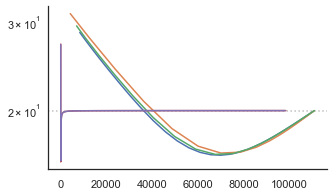

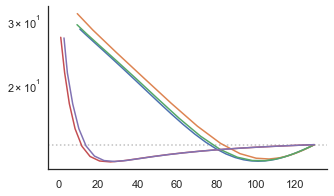

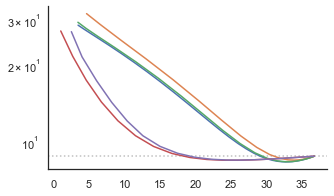

In [8]:
s1 = generate_matrix(dims=100, h=10)
plot(s1, 'gmh10', 1, emin=1e-3, emax=10)

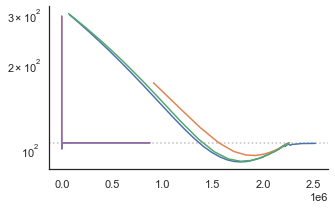

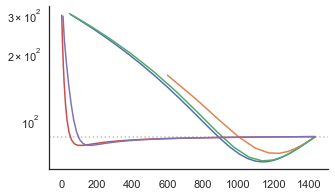

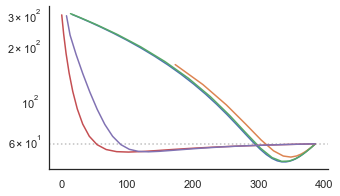

In [9]:
s2= generate_matrix(dims=100, h=100)
plot(s2, 'gmh100', 1, emin=1e-3, emax=10, legend=False)

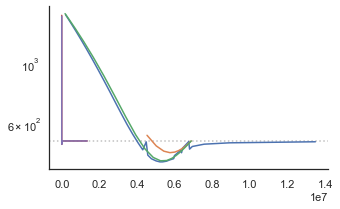

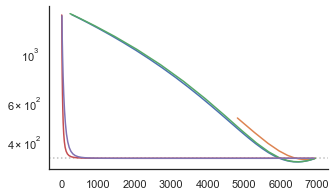

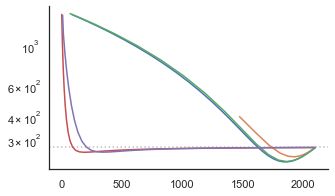

In [10]:
s3 = generate_matrix(dims=100, h=500)
plot(s3, 'gmh500', 1, emin=1e-3, emax=10, legend=False)